In [3]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score , confusion_matrix , silhouette_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.tree import DecisionTreeClassifier, plot_tree


In [4]:
df =  pd.read_csv('mcdonalds.csv')
df

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,No,Yes,No,Yes,No,Yes,Yes,No,Yes,No,No,-3,61,Every three months,Female
1,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,No,No,+2,51,Every three months,Female
2,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,+1,62,Every three months,Female
3,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,Yes,+4,69,Once a week,Female
4,No,Yes,No,Yes,Yes,Yes,Yes,No,No,Yes,No,+2,49,Once a month,Male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448,No,Yes,No,Yes,Yes,No,No,No,Yes,No,Yes,I hate it!-5,47,Once a year,Male
1449,Yes,Yes,No,Yes,No,No,Yes,Yes,No,Yes,No,+2,36,Once a week,Female
1450,Yes,Yes,No,Yes,No,Yes,No,Yes,Yes,No,No,+3,52,Once a month,Female
1451,Yes,Yes,No,No,No,Yes,Yes,Yes,No,Yes,No,+4,41,Every three months,Male


In [12]:
df.iloc[11]

yummy              1
convenient         0
spicy              0
fattening          0
greasy             1
fast               0
cheap              1
tasty              1
expensive          0
healthy            0
disgusting         1
Like               7
Age               11
VisitFrequency     2
Gender             1
Name: 11, dtype: int64

In [ ]:
# Categorical to binary
df[df.iloc[1:11].columns] = df[df.iloc[1:11].columns].apply(lambda x: pd.factorize(x)[0]) 
df

,yummy,convenient,spicy,fattening,greasy,fast,cheap,tasty,expensive,healthy,disgusting,Like,Age,VisitFrequency,Gender
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,1,0,0,1,0,0,0,1,1,0,0
2,0,0,1,0,1,0,1,1,0,1,0,2,2,0,0
3,1,0,0,0,1,0,0,1,1,0,1,3,3,1,0
4,0,0,0,0,1,0,0,0,1,1,0,1,4,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1448,0,0,0,0,1,1,1,0,0,0,1,5,17,3,1
1449,1,0,0,0,0,1,0,1,1,1,0,1,20,1,0
1450,1,0,0,0,0,0,1,1,0,0,0,7,35,2,0
1451,1,0,0,1,0,0,0,1,1,1,0,3,19,0,1


In [13]:
# normalization or scaling data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

In [ ]:
 # Reduce to 2 components
pca = PCA(n_components=2) 
pca_results = pca.fit_transform(scaled_data)

pca_df = pd.DataFrame(pca_results, columns=['PC1', 'PC2'])
result_df = pd.concat([df, pca_df], axis=1)
print(result_df)

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c='#41a291', edgecolor='#0e455b', s=100)
plt.title('visualization of PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

Clustering using K means

In [14]:
wss = []  # Store within-cluster sum of squares
cluster_range = range(2, 9) #for evaluating different cluster numbers
n_boot = 20
ari_scores = {k: [] for k in cluster_range}
print(ari_scores)

{2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}


In [15]:
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=1234)
    kmeans.fit(scaled_data)
    wss.append(kmeans.inertia_) #kmeans.inertia_ gives wss values
print(wss)    

[18710.12322329402, 17228.464686383544, 15861.566529056203, 14711.081210983013, 13744.708100234764, 13131.79857858592, 12596.560708535355]


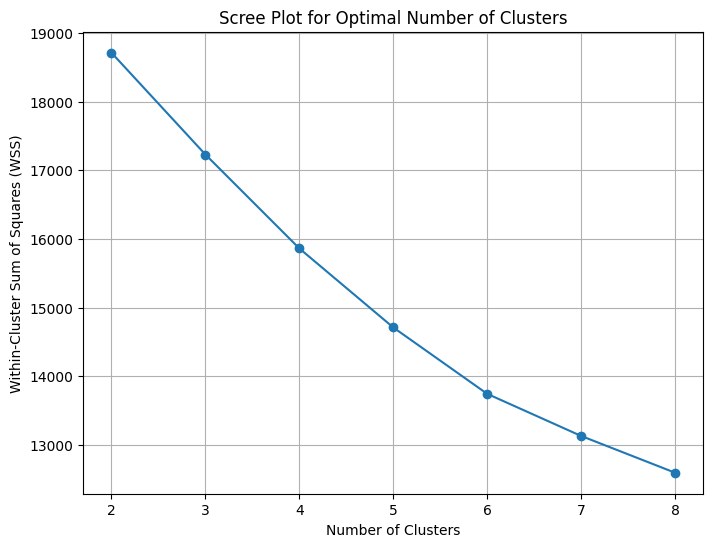

In [16]:
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, wss, marker='o')
plt.title('Scree Plot for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WSS)')
plt.grid(True)
plt.show()

In [125]:
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=1234)
    kmeans.fit(scaled_data)
    labels = kmeans.labels_
    
    # applying bootstrapping
    for _ in range(n_boot):
        sample_indices = np.random.choice(len(scaled_data), len(scaled_data), replace=True) #selecting random samples
        bootstrap_data = scaled_data[sample_indices]
        kmeans_bootstrap = KMeans(n_clusters=k, n_init=10, random_state=1234)
        kmeans_bootstrap.fit(bootstrap_data)
        bootstrap_labels = kmeans_bootstrap.labels_
        
        # Adjusted Rand Index
        ari = adjusted_rand_score(labels[sample_indices], bootstrap_labels)
        ari_scores[k].append(ari)

# Plot Adjusted Rand Index for Stability
mean_ari = [np.mean(ari_scores[k]) for k in cluster_range]



In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, mean_ari, marker='o')
plt.title('Cluster Stability via Bootstrapping')
plt.xlabel('Number of Clusters')
plt.ylabel('Adjusted Rand Index (ARI)')
plt.grid(True)
plt.show()
# from the figure the optimal number of clusters would be 2


mixture plots

In [127]:
# initialise bic and aic for evaluating optimal clusters
bic_scores = []
aic_scores = []

for k in range(2, 9):  # For k = 2 to 8
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(scaled_data)
    
    bic_scores.append(gmm.bic(scaled_data))  # BIC
    aic_scores.append(gmm.aic(scaled_data))  # AIC


In [ ]:
# pltot aic bic scores
plt.plot(cluster_range, aic_scores, label="AIC")
plt.plot(cluster_range, bic_scores, label="BIC")
plt.xlabel("Number of Components (k)")
plt.ylabel("Information Criteria")
plt.legend()
plt.show()

In [ ]:
k = 4  # Assume k=4 for this example
best_gmm = GaussianMixture(n_components=k, random_state=42)
best_gmm.fit(scaled_data)


kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(scaled_data)
kmeans_clusters = kmeans.labels_

# Step 4: Compare the KMeans clusters and GMM mixture clusters
gmm_clusters = best_gmm.predict(scaled_data)

# Compare clustering results
print("KMeans vs GMM clustering comparison:")
print("KMeans clusters:", np.unique(kmeans_clusters))
print("GMM clusters:", np.unique(gmm_clusters))

In [ ]:

# Contingency table for the new comparison
conf_matrix_from_kmeans = confusion_matrix(kmeans_clusters, gmm_clusters)
print('confusion matrix for comparison \n',conf_matrix_from_kmeans)

regression model

In [132]:
df['Like.n'] = 6 - pd.to_numeric(df['Like'])
X = df.iloc[:, 0:11]  # Assuming first 11 columns are your features
y = df['Like.n']

In [ ]:

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
gmm = GaussianMixture(n_components=2, random_state=42)
gmm_clusters = gmm.fit_predict(X_scaled)  # Predict the clusters

df['Cluster'] = gmm_clusters

for cluster in np.unique(gmm_clusters):
    # Extract data for the current cluster
    cluster_data = df[df['Cluster'] == cluster]
    X_cluster = cluster_data.iloc[:, 0:11]  # Features for this cluster
    X_cluster = scaler.transform(X_cluster)  # Scale the features for the current cluster
    y_cluster = cluster_data['Like.n']  # Target variable for this cluster

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_cluster, y_cluster, test_size=0.2, random_state=42)

    
    model = LinearRegression() 
    model.fit(X_train, y_train) #fit regression model

    y_pred = model.predict(X_test)

    # Step 10: Plot the actual vs predicted values for this cluster
    plt.scatter(y_test, y_pred)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Cluster {cluster} - Actual vs Predicted')
    plt.show()

    # Compute R-squared for this cluster's regression model
    print(f"Cluster {cluster} R-squared:", model.score(X_test, y_test))

# Optionally, you could use KMeans or other clustering methods as well.


Segment Profiling

In [ ]:

from scipy.cluster.hierarchy import linkage, fcluster

#  Hierarchical Clustering 
# Use Euclidean distance and perform linkage
X = df.drop(['Cluster', 'Like', 'Gender'],axis=1)  # Drop categorical variables
distance_matrix = linkage(X, method='ward')

# Assign clusters using fcluster (you can change the number of clusters as needed)
df['Cluster'] = fcluster(distance_matrix, 4, criterion='maxclust')

# plotting bar chart
# Visualizing clusters in a bar chart
plt.figure(figsize=(10, 6))
sns.barplot(x=df['Cluster'].value_counts().index, y=df['Cluster'].value_counts().values, palette="viridis")
plt.title('Cluster Distribution')
plt.xlabel('Cluster')
plt.ylabel('Frequency')
plt.show()


#   Plotting decision tree
# Convert 'Gender' and 'Like' to categorical
df['Gender'] = df['Gender'].astype('category')
df['Like.n'] = df['Like.n'].astype('category')

X = df[['Age', 'VisitFrequency', 'Gender', 'Like.n']]
y = df['Cluster'] == 3  

# Initialize and train a Decision Tree Classifier
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X, y)

# Plot the decision tree
plt.figure(figsize=(12, 8))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=["Not Cluster 3", "Cluster 3"])
plt.title('Decision Tree for Cluster 3')
plt.show()


In [ ]:
df.columns

Target segments

In [ ]:

# Convert 'Like.n' to numeric if categorical
df['Like.n'] = df['Like.n'].map({'Yes': 1, 'No': 0}) 

# Calculate the mean VisitFrequency for each cluster
visit = df.groupby('Cluster')['VisitFrequency'].mean()

# Calculate the mean Like.n for each cluster
like = df.groupby('Cluster')['Like.n'].mean()

# Calculate the mean Female 
female = (df['Gender'] == 'Female').astype(int).groupby(df['Cluster']).mean()

# Print the results
print("Visit Frequency by Cluster:",visit)
print("\nLike.n by Cluster:",like)
print("\nFemale (as % of Gender) by Cluster:",female)
